In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [26]:
sns.set_palette(sns.color_palette('Set1'))

In [2]:
#load a sample set
df = pd.read_csv('test_Feb_2016-Mar_2018.csv')

In [3]:
def Date_filter(df, startYear, startMonth, endYear, endMonth):
    df['Year'] = df['DATE'].str.split('-', expand=True)[0]
    df['Month'] = df['DATE'].str.split('-', expand=True)[1]
    if startYear == endYear:
        df_mod = df[(df['Month'].astype(int) >= startMonth) & 
                (df['Month'].astype(int) <= endMonth) & 
                (df['Year'].astype(int) == startYear)]
        #df_mod.to_csv(file_name)
        return(df_mod)
    elif startYear <= endYear:
        df1 = df[(df['Year'].astype(int) >= startYear+1) & 
                 (df['Year'].astype(int) <= endYear-1)]
        df2 = df[(df['Month'].astype(int) >= startMonth) & 
                (df['Month'].astype(int) <= 12) & 
                (df['Year'].astype(int) == startYear)]
        df3 = df[(df['Month'].astype(int) >= 1) & 
                (df['Month'].astype(int) <= endMonth) & 
                (df['Year'].astype(int) == endYear)]
        df_mod = pd.concat([df1, df2, df3])
        return(df_mod)

In [4]:
JanOct_2016 = Date_filter(df,2016,1,2016,10)
Nov_2016 = Date_filter(df,2016,11,2016,11)

In [44]:
JanOct_2016 = JanOct_2016[JanOct_2016['AH1_RES_BUS_INDC'] == 'R']
JanOct_2016 = JanOct_2016[JanOct_2016['SUPP1_BUS_PANDER'] == 'N']
JanOct_2016_mod = JanOct_2016[JanOct_2016['EMAIL_OPTIN_IND'] == 'Y']
Nov_2016 = Nov_2016[Nov_2016['AH1_RES_BUS_INDC'] == 'R']
Nov_2016 = Nov_2016[Nov_2016['SUPP1_BUS_PANDER'] == 'N']
Nov_2016_mod = Nov_2016[Nov_2016['EMAIL_OPTIN_IND'] == 'Y']

### Model Year

In [23]:
JanOct_2016_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525060 entries, 5 to 1441431
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   STORE_ID          525060 non-null  int64  
 1   TRAN_ID           525060 non-null  int64  
 2   DATE              525060 non-null  object 
 3   ARTICLE_ID        525060 non-null  int64  
 4   INDIV_ID          525060 non-null  float64
 5   VEHICLE_ID        525060 non-null  int64  
 6   UNITS             525060 non-null  float64
 7   SALES             525060 non-null  float64
 8   STATE_CODE        525060 non-null  object 
 9   ZIP_CODE          525060 non-null  int64  
 10  MSA               437909 non-null  object 
 11  MAKE              2058 non-null    object 
 12  MODEL             2058 non-null    object 
 13  SUB_MODEL         1754 non-null    object 
 14  MODEL_YEAR        2058 non-null    float64
 15  PROD_GROUP_CODE   525060 non-null  float64
 16  PROD_GROUP_DESC   5

<AxesSubplot:>

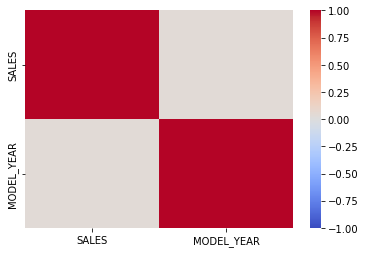

In [33]:
sns.heatmap(JanOct_2016_mod[['SALES','MODEL_YEAR']].corr(),cmap ='coolwarm',vmin=-1,vmax=1)

In [34]:
JanOct_2016_mod['MODEL_AGE'] = pd.to_datetime(JanOct_2016_mod['DATE'].min()).year - JanOct_2016_mod['MODEL_YEAR']

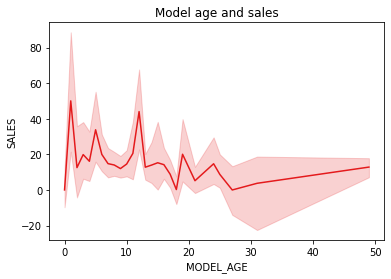

In [41]:
sns.lineplot(data=JanOct_2016_mod, x='MODEL_AGE', y = 'SALES')
plt.title('Model age and sales')
plt.show()

#### Model age < 15

### Coding for Feature Engineering on Accre

In [56]:
dy = JanOct_2016_mod
dn = Nov_2016_mod

In [156]:
targets = dn[dn['PROD_GROUP_CODE'] == 5]['INDIV_ID'].unique()
year_indivs = pd.DataFrame({'indiv':dy['INDIV_ID'].unique()})
year_indivs['label'] = np.where(year_indivs['indiv'].isin(targets), 1, 0) 

In [157]:
year_indivs

,indiv,label
0,321490116.0,0
1,280953722.0,0
2,281559848.0,0
3,264266149.0,0
4,255458702.0,0
...,...,...
39477,285607739.0,0
39478,258529649.0,0
39479,260373206.0,0
39480,259933700.0,0


#### Above is to imitate the process that has been implemented on accre

In [158]:
dy['MODEL_AGE'] = pd.to_datetime(dy['DATE'].min()).year - dy['MODEL_YEAR']

In [159]:
#Model age could be EDITED 
less_than_15_modelage = dy.query('MODEL_AGE < 15')['VEHICLE_ID']

In [160]:
indiv_less_than_15_modelage = dy[dy['VEHICLE_ID'].isin(less_than_15_modelage)]['INDIV_ID']

In [161]:
year_indivs['indiv_less_than_15_modelage'] = np.where(year_indivs.indiv.isin(indiv_less_than_15_modelage), 1, 0)

In [162]:
year_indivs['indiv_less_than_15_modelage'].value_counts()

0    39325
1      157
Name: indiv_less_than_15_modelage, dtype: int64

### MAKE/MODEL/SUBMODEL

In [163]:
cat = ['MAKE', 'MODEL', 'SUB_MODEL']
for i in cat:
    dq = dy[i].groupby([dy['TRAN_ID'], dy['DATE']]).count().to_frame()
    print(i,  'Data Miss Rate', len(dq[dq[i]==0]) / len(dq[i]))

MAKE Data Miss Rate 0.9962199432991495
MODEL Data Miss Rate 0.9962199432991495
SUB_MODEL Data Miss Rate 0.9968616195909605


#### Using this step on Accre to check the miss rate of MAKE/MODEL/SUB_MODEL

#### Top 5

In [164]:
for i in cat:
    T = dy[i].groupby([dy['TRAN_ID'], dy['DATE']]).value_counts().to_frame().rename(columns = {i:'count'})
    T.reset_index(inplace =True)
    T.drop('count', axis = 1, inplace = True)
    T = T.groupby(i).count()
    T.reset_index(inplace = True)
    T.drop('DATE', axis = 1, inplace = True)
    T.rename(columns = {'TRAN_ID':'total_trans'}, inplace = True)
    print(i, 'top 5 share in transactions:', T.sort_values('total_trans', ascending = False)[:5].sum()[1]/T['total_trans'].sum())

MAKE top 5 share in transactions: 0.4845679012345679
MODEL top 5 share in transactions: 0.11419753086419752
SUB_MODEL top 5 share in transactions: 0.3643122676579926


#### Top 10

In [165]:
for i in cat:
    T = dy[i].groupby([dy['TRAN_ID'], dy['DATE']]).value_counts().to_frame().rename(columns = {i:'count'})
    T.reset_index(inplace =True)
    T.drop('count', axis = 1, inplace = True)
    T = T.groupby(i).count()
    T.reset_index(inplace = True)
    T.drop('DATE', axis = 1, inplace = True)
    T.rename(columns = {'TRAN_ID':'total_trans'}, inplace = True)
    print(i, 'top 10 share in transactions:', T.sort_values('total_trans', ascending = False)[:10].sum()[1]/T['total_trans'].sum())

MAKE top 10 share in transactions: 0.7253086419753086
MODEL top 10 share in transactions: 0.19135802469135801
SUB_MODEL top 10 share in transactions: 0.5390334572490706


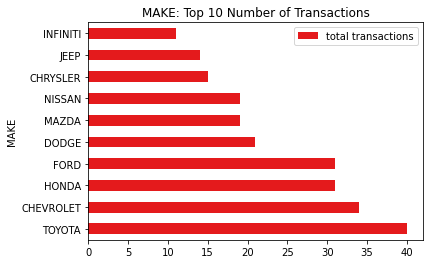

In [166]:
T = dy['MAKE'].groupby([dy['TRAN_ID'], dy['DATE']]).value_counts().to_frame().rename(columns = {'MAKE':'count'})
T.reset_index(inplace =True)
T.drop('count', axis = 1, inplace = True)
T = T.groupby('MAKE').count()
T.drop('DATE', axis = 1, inplace = True)
T.rename(columns = {'TRAN_ID':'total transactions'}, inplace = True)
T.sort_values('total transactions', ascending = False)[:10].plot.barh()
plt.title('MAKE: Top 10 Number of Transactions')
plt.show()

#### so that using top 10 MAKE

In [167]:
top_10_make = T.sort_values('total transactions', ascending = False)[:10]

In [168]:
top_10_make.reset_index(inplace =True)
top_10_make = top_10_make['MAKE']

In [169]:
indiv_top_10_make = dy[dy['MAKE'].isin(top_10_make)]['INDIV_ID']

In [170]:
year_indivs['indiv_top_10_make'] = np.where(year_indivs.indiv.isin(indiv_top_10_make), 1, 0)

In [171]:
year_indivs['indiv_top_10_make'].value_counts()

0    39350
1      132
Name: indiv_top_10_make, dtype: int64

#### Same, if we have to use model and sub_model, just edit the column name

### Proportion

In [172]:
sales_vehicle_id = dy.groupby(['VEHICLE_ID'])['SALES'].sum().to_frame()

In [173]:
sales_vehicle_id.reset_index(inplace =True)

In [174]:
tire_sales_vehicle_id = dy[dy['PROD_GROUP_CODE']==5].groupby(['VEHICLE_ID'])['SALES'].sum().to_frame()

In [175]:
tire_sales_vehicle_id.reset_index(inplace =True)
tire_sales_vehicle_id.rename(columns = {'SALES': 'TIRE_SALES'},inplace = True)

In [176]:
prop_sales_vehicle_id = pd.merge(sales_vehicle_id, tire_sales_vehicle_id, on = 'VEHICLE_ID', how= 'left')

In [177]:
prop_sales_vehicle_id

,VEHICLE_ID,SALES,TIRE_SALES
0,1,101856.85,89723.63
1,409421,131.76,NaN
2,1302297,623.05,NaN
3,5132467,25.00,NaN
4,5145643,1792.96,1792.96
...,...,...,...
50875,998850457,96.46,NaN
50876,1001654250,-14.40,NaN
50877,1001742837,97.94,NaN
50878,1005758642,476.78,NaN


In [178]:
prop_sales_vehicle_id['TIRE_SALES'].fillna(0,inplace = True)

In [179]:
prop_sales_vehicle_id['PROP'] =  prop_sales_vehicle_id['TIRE_SALES']/prop_sales_vehicle_id['SALES']

In [180]:
prop_sales_vehicle_id

,VEHICLE_ID,SALES,TIRE_SALES,PROP
0,1,101856.85,89723.63,0.88088
1,409421,131.76,0.00,0.00000
2,1302297,623.05,0.00,0.00000
3,5132467,25.00,0.00,0.00000
4,5145643,1792.96,1792.96,1.00000
...,...,...,...,...
50875,998850457,96.46,0.00,0.00000
50876,1001654250,-14.40,0.00,-0.00000
50877,1001742837,97.94,0.00,0.00000
50878,1005758642,476.78,0.00,0.00000


#### Notice row 50876: if the value equals to -0, what should I do for it?